In [ ]:
# Instead of original training dataframe, we need to make a table of
# with climate data as columns and individual months for individual glaciers
# as rows. In training we need to batch the months to match summer, winter and
# annual mass balance, aggregate the results for each month and evaluate it against
# the summer, winter and annual mass balance using a custom loss function. We can shuffle the batches, 
# but we need to keep the respective batches themselves in the correct order. 

In [76]:
import numpy as np
import pandas as pd
import xgboost as xgb
from plotting_functions import plot_prediction
from sklearn.model_selection import KFold
from itertools import product
from sklearn.model_selection import GroupKFold
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from plotting_functions import plot_prediction_per_fold



## Monthly predictions using dummy dataset

In [2]:
# Create dummy feature dataset
def create_feature_dataset(n_rows):

    np.random.seed(0)

    data = {
        "t2m": np.random.uniform(-5, 5, n_rows), 
        "tp": np.random.uniform(0, 100, n_rows),  
        "fal": np.random.uniform(0, 1, n_rows),   
        "ssr": np.random.uniform(0, 100, n_rows) 
    }

    df = pd.DataFrame(data)

    return df

num_rows = 600
    
# Create dataset
df_features = create_feature_dataset(num_rows)

# Features
X_values = df_features.values

# Number of months to aggregate
months = 6
num_rows_y = int(num_rows/months)

# Target
y_values = np.random.uniform(-5, 5, num_rows_y)

# Target repeated months times
y_values_rep = np.repeat(y_values, months)

### Training using low-level Booster interface

In [10]:
# When defining a custom loss function with the native XGBoost api, input arguments
# are (predictions, Dmatrix). Dmatrix contains targets. 
def custom_mse_native(y_pred, dtrain):
    """
    Custom Mean Squared Error loss for seasonal data.
    """
    # Get the true values
    y_true = dtrain.get_label()

    # Assuming 6-month seasons, reshape predictions and true values
    y_pred_seasonal = y_pred.reshape(-1, 6)
    y_true_seasonal = y_true.reshape(-1, 6)

    # Aggregate predictions and true values over the season
    # Predictions are summed over months, true values are repeated so mean is taken
    y_pred_agg = np.sum(y_pred_seasonal, axis=1)
    y_true_agg = np.mean(y_true_seasonal, axis=1)

    # Calculate the gradient (first derivative) and hessian (second derivative) for MSE
    gradient = y_pred_agg - y_true_agg
    hessian = np.ones_like(gradient)

    # Reshape gradient and hessian to match the original shape
    gradient = np.repeat(gradient, 6)
    hessian = np.repeat(hessian, 6)

    return gradient, hessian

# Convert data to DMatrix, data format used in native XGBoost
dtrain = xgb.DMatrix(X_values, label=y_values_rep)

# Parameters
params = {'max_depth': 6, 'eta': 0.3}

# Train model
# num_boost_round is in the case of the Booster interface the same as n_estimators in XGBregressor
model = xgb.train(params, dtrain, obj=custom_mse_native, num_boost_round=100)


In [11]:
preds = model.predict(dtrain)
print(preds[:6].sum())
print(y_values[0])

3.8658118
3.8668322084745235


### Using Scikit-learn XGBRegressor interface

In [14]:
# When defining a custom loss function with the scikit-learn XGBoost api, 
# input arguments are (target, predictions)
def custom_mse_sklearn(y_true, y_pred):
    
    # Reshape the predictions and true values to represent seasons (6 months in this case)
    y_pred_seasonal = y_pred.reshape(-1, 6)
    y_true_seasonal = y_true.reshape(-1, 6)

    # Aggregate predictions and true values over the season
    y_pred_agg = np.sum(y_pred_seasonal, axis=1)
    y_true_agg = np.mean(y_true_seasonal, axis=1)

    # Calculate the gradient (first derivative) and hessian (second derivative) for MSE
    gradient = y_pred_agg - y_true_agg
    hessian = np.ones_like(gradient)

    # Reshape gradient and hessian to match the original shape
    gradient = np.repeat(gradient, 6)
    hessian = np.repeat(hessian, 6)

    return gradient, hessian

# Initialize XGBRegressor with the custom objective
model_reg = xgb.XGBRegressor(objective=custom_mse_sklearn)

# Train the model
model = model_reg.fit(X_values, y_values_rep)


In [15]:
preds = model.predict(X_values)

In [16]:
preds[:10]

array([0.6568314 , 0.7752539 , 0.8081221 , 1.2794617 , 0.17567207,
       0.17047073, 0.8575948 , 0.430232  , 0.12330425, 0.95460874],
      dtype=float32)

In [17]:
print(preds[:6].sum())
print(y_values[0])


3.8658118
3.8668322084745235


## Test monthly predictions using summer mass balance

### Import and process data

In [18]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_annual = data[data['balance_netto'].notna()]
glacier_data_annual.reset_index(drop=True, inplace=True)

glacier_data_winter = data[data['balance_winter'].notna()]
glacier_data_winter.reset_index(drop=True, inplace=True)

glacier_data_summer = data[data['balance_summer'].notna()]
glacier_data_summer.reset_index(drop=True, inplace=True)

C:\Users\kasj\AppData\Local\Temp\ipykernel_11600\3172944082.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [20]:
# Manually select test glaciers (14 glaciers)
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]

# Get test dataset for each of annual, winter and summer mass balance
df_test_annual = glacier_data_annual[glacier_data_annual['BREID'].isin(test_glaciers)]
df_test_winter = glacier_data_winter[glacier_data_winter['BREID'].isin(test_glaciers)]
df_test_summer = glacier_data_summer[glacier_data_summer['BREID'].isin(test_glaciers)]
# 54 has 189 points
# 703 has 30 points
# 941 has 70 points
# 1280 has 71 points
# 2320 has 83 points
# 2478 has 89 points
# 2769 has 121 points
# 3133 has 38 points
# 3137 has 65 points
# 3138 has 6 points
# 3141 has 72 points

# Get training dataset for each of annual, winter and summer mass balance
df_train_annual = glacier_data_annual[~glacier_data_annual['BREID'].isin(test_glaciers)]
df_train_winter = glacier_data_winter[~glacier_data_winter['BREID'].isin(test_glaciers)]
df_train_summer = glacier_data_summer[~glacier_data_summer['BREID'].isin(test_glaciers)]

# Add number of months to each dataframe
df_train_annual['n_months']=12
df_train_winter['n_months']=8
df_train_summer['n_months']=6
df_test_annual['n_months']=12
df_test_winter['n_months']=8
df_test_summer['n_months']=6

print(f'Train/test annual: {len(df_train_annual)}/{len(df_test_annual)}')
print(f'Train/test winter: {len(df_train_winter)}/{len(df_test_winter)}')
print(f'Train/test summer: {len(df_train_summer)}/{len(df_test_summer)}')
print(f'All train/test: {len(df_train_annual)+len(df_train_winter)+len(df_train_summer)} / {len(df_test_annual)+len(df_test_winter)+len(df_test_summer)}')
print(f'Fraction train/test: {(len(df_train_annual)+len(df_train_winter)+len(df_train_summer)) / (len(df_test_annual)+len(df_test_winter)+len(df_test_summer)+len(df_train_annual)+len(df_train_winter)+len(df_train_summer))} / {(len(df_test_annual)+len(df_test_winter)+len(df_test_summer)) /(len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer))}')
print(f'Total entries: {len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer)}')


Train/test annual: 2845/1065
Train/test winter: 2752/1000
Train/test summer: 2901/1028
All train/test: 8498 / 3093
Fraction train/test: 0.7331550340781641 / 0.26684496592183593
Total entries: 11591


C:\Users\kasj\AppData\Local\Temp\ipykernel_11600\1108104880.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_annual['n_months']=12
C:\Users\kasj\AppData\Local\Temp\ipykernel_11600\1108104880.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_winter['n_months']=8
C:\Users\kasj\AppData\Local\Temp\ipykernel_11600\1108104880.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [21]:
# Select columns to drop
cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year', 'lat','lon', 'slope_factor']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
sol_rad_net = ['ssr_oct','ssr_nov','ssr_dec','ssr_jan','ssr_feb','ssr_mar','ssr_apr','ssr_may','ssr_jun','ssr_jul','ssr_aug','ssr_sep']
sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']
#sol_rad_down = ['ssrd_oct','ssrd_nov','ssrd_dec','ssrd_jan','ssrd_feb','ssrd_mar','ssrd_apr','ssrd_may','ssrd_jun','ssrd_jul','ssrd_aug','ssrd_sep']
u_wind = ['u10_oct','u10_nov','u10_dec','u10_jan','u10_feb','u10_mar','u10_apr','u10_may','u10_jun','u10_jul','u10_aug','u10_sep']
v_wind = ['v10_oct','v10_nov','v10_dec','v10_jan','v10_feb','v10_mar','v10_apr','v10_may','v10_jun','v10_jul','v10_aug','v10_sep']
#f_albedo = ['fal_oct','fal_nov','fal_dec','fal_jan','fal_feb','fal_mar','fal_apr','fal_may','fal_jun','fal_jul','fal_aug','fal_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
                         dewpt_temp, surface_pressure, sol_rad_net, sol_therm_down, u_wind, v_wind] for y in x]

# Select features for training
df_train_annual_clean = df_train_annual.drop(drop_cols, axis=1)
df_train_winter_clean = df_train_winter.drop(drop_cols, axis=1)
df_train_summer_clean = df_train_summer.drop(drop_cols, axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_train_summer_clean = df_train_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# df_train_X_... now contains columns of all chosen features and column with annual, winter or summer balance

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        if mon not in mon_winter:
            df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        if mon not in mon_summer:
            df_train_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])

In [22]:
df_train_summer_clean

,BREID,altitude,balance,aspect,slope,t2m_oct,t2m_nov,t2m_dec,t2m_jan,t2m_feb,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,n_months
172,596,990.0,-3.41,2.509464,0.238202,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001702,0.001953,0.004025,0.002591,0.006047,1001.181943,6
173,596,996.0,-2.16,2.474161,0.117946,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.002906,0.003402,0.003066,0.004062,0.004951,1001.181943,6
174,596,988.0,-2.90,2.509464,0.238202,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003094,0.001567,0.003896,0.004033,0.004845,1001.181943,6
175,596,990.0,-3.16,2.478294,0.146882,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000861,0.004021,0.006549,0.003302,0.003687,1001.181943,6
176,596,990.0,-1.90,2.478294,0.146882,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001514,0.004824,0.003683,0.004470,0.001097,1001.181943,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728,3129,1551.0,-2.35,2.115165,0.111223,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003067,0.004948,0.001373,0.001677,0.008620,994.833212,6
3729,3129,1571.0,-1.29,2.312361,0.097301,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.005468,0.009837,0.010945,0.007251,0.008933,994.833212,6
3730,3129,1587.0,-1.80,2.482095,0.070551,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001531,0.006192,0.002394,0.006272,0.007284,994.833212,6
3731,3129,1590.0,-2.81,2.339748,0.073072,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.004337,0.003802,0.004859,0.004397,0.011932,994.833212,6


In [23]:
df_train_summer_clean = df_train_summer_clean.dropna(axis=1, how='all')

In [24]:
df_train_summer_clean.columns.to_list()

['BREID',
 'altitude',
 'balance',
 'aspect',
 'slope',
 't2m_may',
 't2m_jun',
 't2m_jul',
 't2m_aug',
 't2m_sep',
 'fal_may',
 'fal_jun',
 'fal_jul',
 'fal_aug',
 'fal_sep',
 'slhf_may',
 'slhf_jun',
 'slhf_jul',
 'slhf_aug',
 'slhf_sep',
 'str_may',
 'str_jun',
 'str_jul',
 'str_aug',
 'str_sep',
 'sshf_may',
 'sshf_jun',
 'sshf_jul',
 'sshf_aug',
 'sshf_sep',
 'ssrd_may',
 'ssrd_jun',
 'ssrd_jul',
 'ssrd_aug',
 'ssrd_sep',
 'tp_may',
 'tp_jun',
 'tp_jul',
 'tp_aug',
 'tp_sep',
 'altitude_climate',
 'n_months']

In [25]:
# Columns that are not monthly climate variables (identifiers and static variables)
id_vars = ['BREID', 'altitude','balance','aspect','slope','altitude_climate','n_months']

# Extract the unique variable names and month names from the column names
#variables = set(col.split('_')[0] for col in df.columns if col not in id_vars)
#months = set(col.split('_')[-1] for col in df.columns if col not in id_vars)
variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
months_order = ['may', 'jun', 'jul', 'aug', 'sep']

# Prepare a list to hold the reshaped DataFrames for each variable
df_list = []

for var in variables:
    # Filter columns for the current variable and the ID columns
    cols = [col for col in df_train_summer_clean.columns if col.startswith(var) or col in id_vars]
    df_var = df_train_summer_clean[cols]

    # Rename the columns to have just the month
    df_var = df_var.rename(columns=lambda x: x.split('_')[-1] if x not in id_vars else x)

    # Melt the DataFrame to long format and add month order
    df_melted = pd.melt(df_var, id_vars=id_vars, var_name='month', value_name=var)
    df_melted['month'] = pd.Categorical(df_melted['month'], categories=months_order, ordered=True)

    # Append the reshaped DataFrame to the list
    df_list.append(df_melted)

# Combine all reshaped DataFrames
df_final = df_list[0]
for df_temp in df_list[1:]:
    df_final = pd.merge(df_final, df_temp, on=id_vars + ['month'], how='outer')

# Sort the DataFrame based on ID variables and month
df_final = df_final.sort_values(by=id_vars + ['month'])


In [26]:
df_final

,BREID,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
82,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,may,271.778687,93903.000,-393356.0,21712848.0,0.719680,-3898658.75,0.000861
4999,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,jun,274.179108,-142581.000,-456671.5,18036852.0,0.636215,-1912245.25,0.004021
9916,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,jul,277.781219,-530140.000,-1020132.0,13634819.0,0.460673,-1183857.00,0.006549
14833,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,aug,280.827637,-1322854.625,-2858846.0,9900008.0,0.162629,-3083705.75,0.003302
19750,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,sep,277.611938,-535290.250,-1280799.5,5031936.5,0.212322,-2043465.00,0.003687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4884,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,may,274.327118,-927999.500,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
9801,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,jun,277.050171,-842161.375,101172.0,20268490.0,0.551025,-2504472.50,0.007480
14718,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,jul,278.294403,-492371.250,282694.5,15490057.0,0.481296,-862670.75,0.006605
19635,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,aug,280.939240,-1117701.750,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


In [27]:
df_final.reset_index(drop=True, inplace=True)
df_final

,BREID,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,may,271.778687,93903.000,-393356.0,21712848.0,0.719680,-3898658.75,0.000861
1,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,jun,274.179108,-142581.000,-456671.5,18036852.0,0.636215,-1912245.25,0.004021
2,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,jul,277.781219,-530140.000,-1020132.0,13634819.0,0.460673,-1183857.00,0.006549
3,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,aug,280.827637,-1322854.625,-2858846.0,9900008.0,0.162629,-3083705.75,0.003302
4,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,sep,277.611938,-535290.250,-1280799.5,5031936.5,0.212322,-2043465.00,0.003687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24580,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,may,274.327118,-927999.500,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
24581,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,jun,277.050171,-842161.375,101172.0,20268490.0,0.551025,-2504472.50,0.007480
24582,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,jul,278.294403,-492371.250,282694.5,15490057.0,0.481296,-862670.75,0.006605
24583,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,aug,280.939240,-1117701.750,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


In [28]:
# Prepare test

# Select features for training
df_test_annual_clean = df_test_annual.drop(drop_cols, axis=1)
df_test_winter_clean = df_test_winter.drop(drop_cols, axis=1)
df_test_summer_clean = df_test_summer.drop(drop_cols, axis=1)
df_test_annual_clean = df_test_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_test_winter_clean = df_test_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_test_summer_clean = df_test_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_test_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_test_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_test_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        if mon not in mon_winter:
            df_test_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        if mon not in mon_summer:
            df_test_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
df_test_all = pd.concat([df_test_annual_clean, df_test_summer_clean, df_test_winter_clean])
df_test_all.reset_index(drop=True, inplace=True)


In [29]:
df_test_summer_clean = df_test_summer_clean.dropna(axis=1, how='all')

In [30]:
df_test_summer_clean

,BREID,altitude,balance,aspect,slope,t2m_may,t2m_jun,t2m_jul,t2m_aug,t2m_sep,...,ssrd_jul,ssrd_aug,ssrd_sep,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,n_months
0,54,471.0,-6.24,0.629597,0.278773,277.677979,283.339630,283.829285,283.778412,280.982513,...,15538729.0,10510849.0,6908671.0,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,6
1,54,439.0,-4.35,0.585924,0.296590,273.853424,278.533508,286.991089,283.409485,278.292114,...,18042530.0,11039758.0,5959149.5,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,6
2,54,444.0,-4.17,0.663261,0.302508,275.326904,277.934570,282.700439,284.425964,280.746399,...,16689025.0,10871432.0,5295579.5,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,6
3,54,444.0,-4.37,0.663261,0.302508,277.405426,279.781555,284.442657,282.017212,281.270203,...,12798462.0,10218002.0,5514606.5,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,6
4,54,468.0,-4.05,0.836757,0.309196,272.579590,278.621582,283.518036,282.460541,280.259796,...,14254989.0,10143777.0,7109445.5,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3924,3141,1078.0,-3.57,2.906044,0.131717,276.051880,279.342010,282.147797,282.897827,277.707581,...,13498130.0,12668262.0,6896097.0,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759,6
3925,3141,1078.0,-4.29,2.906044,0.131717,277.164032,280.542206,284.284760,282.710297,280.058624,...,16972544.0,13084008.0,7385662.5,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759,6
3926,3141,1079.0,-3.80,2.906044,0.131717,274.069031,278.133453,281.378021,283.121002,280.627228,...,14995219.0,13300601.0,8539609.0,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759,6
3927,3141,1078.0,-4.38,2.906044,0.131717,278.187347,283.209045,282.545563,282.466614,282.774078,...,12746544.0,10608194.0,8065051.0,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759,6


In [31]:
# Columns that are not monthly climate variables (identifiers and static variables)
id_vars = ['BREID', 'altitude','balance','aspect','slope','altitude_climate','n_months']

# Extract the unique variable names and month names from the column names
#variables = set(col.split('_')[0] for col in df.columns if col not in id_vars)
#months = set(col.split('_')[-1] for col in df.columns if col not in id_vars)
variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
months_order = ['may', 'jun', 'jul', 'aug', 'sep']

# Prepare a list to hold the reshaped DataFrames for each variable
df_list = []

for var in variables:
    # Filter columns for the current variable and the ID columns
    cols = [col for col in df_test_summer_clean.columns if col.startswith(var) or col in id_vars]
    df_var = df_test_summer_clean[cols]

    # Rename the columns to have just the month
    df_var = df_var.rename(columns=lambda x: x.split('_')[-1] if x not in id_vars else x)

    # Melt the DataFrame to long format and add month order
    df_melted = pd.melt(df_var, id_vars=id_vars, var_name='month', value_name=var)
    df_melted['month'] = pd.Categorical(df_melted['month'], categories=months_order, ordered=True)

    # Append the reshaped DataFrame to the list
    df_list.append(df_melted)

# Combine all reshaped DataFrames
df_test_final = df_list[0]
for df_temp in df_list[1:]:
    df_test_final = pd.merge(df_test_final, df_temp, on=id_vars + ['month'], how='outer')

# Sort the DataFrame based on ID variables and month
df_test_final = df_test_final.sort_values(by=id_vars + ['month'])

In [32]:
df_test_final

,BREID,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
10,54,400.0,-4.18,1.283742,0.162952,341.227919,6,may,274.472870,2.552786e+05,-348422.00,18054698.0,0.663828,-2917164.75,0.003328
1416,54,400.0,-4.18,1.283742,0.162952,341.227919,6,jun,279.946289,-2.202645e+05,-1346158.00,20163438.0,0.423285,-3229566.50,0.002498
2822,54,400.0,-4.18,1.283742,0.162952,341.227919,6,jul,281.683960,-2.243898e+06,-4249753.00,13524089.0,0.131924,-4107109.50,0.004562
4228,54,400.0,-4.18,1.283742,0.162952,341.227919,6,aug,281.627777,-1.479509e+06,-3182574.25,10970805.0,0.130799,-4367902.00,0.002152
5634,54,400.0,-4.18,1.283742,0.162952,341.227919,6,sep,279.607697,-1.618945e+05,-1336711.50,5659001.5,0.132435,-3476266.75,0.002351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,3141,1585.0,-1.42,3.830213,0.013718,1040.093546,6,may,277.900391,1.226588e+05,-109966.00,22470520.0,0.670076,-3584976.00,0.001143
2781,3141,1585.0,-1.42,3.830213,0.013718,1040.093546,6,jun,279.539368,2.505575e+05,33005.50,18861446.0,0.653503,-1534874.25,0.007373
4187,3141,1585.0,-1.42,3.830213,0.013718,1040.093546,6,jul,284.332581,-1.189755e+05,-1342583.50,18833054.0,0.556072,-1499186.75,0.005612
5593,3141,1585.0,-1.42,3.830213,0.013718,1040.093546,6,aug,282.079468,-1.170063e+06,-2647197.50,12839022.0,0.385999,-2697184.00,0.005260


In [33]:
# Select features for training
df_test_X = df_test_final.drop(['balance','BREID','n_months','month'], axis=1)

# Select labels for training
df_test_y = df_test_final[['balance']]

# Get arrays of features and targets
X_test, y_test = df_test_X.values, df_test_y.values

In [34]:
df_test_X

,altitude,aspect,slope,altitude_climate,t2m,sshf,slhf,ssrd,fal,str,tp
10,400.0,1.283742,0.162952,341.227919,274.472870,2.552786e+05,-348422.00,18054698.0,0.663828,-2917164.75,0.003328
1416,400.0,1.283742,0.162952,341.227919,279.946289,-2.202645e+05,-1346158.00,20163438.0,0.423285,-3229566.50,0.002498
2822,400.0,1.283742,0.162952,341.227919,281.683960,-2.243898e+06,-4249753.00,13524089.0,0.131924,-4107109.50,0.004562
4228,400.0,1.283742,0.162952,341.227919,281.627777,-1.479509e+06,-3182574.25,10970805.0,0.130799,-4367902.00,0.002152
5634,400.0,1.283742,0.162952,341.227919,279.607697,-1.618945e+05,-1336711.50,5659001.5,0.132435,-3476266.75,0.002351
...,...,...,...,...,...,...,...,...,...,...,...
1375,1585.0,3.830213,0.013718,1040.093546,277.900391,1.226588e+05,-109966.00,22470520.0,0.670076,-3584976.00,0.001143
2781,1585.0,3.830213,0.013718,1040.093546,279.539368,2.505575e+05,33005.50,18861446.0,0.653503,-1534874.25,0.007373
4187,1585.0,3.830213,0.013718,1040.093546,284.332581,-1.189755e+05,-1342583.50,18833054.0,0.556072,-1499186.75,0.005612
5593,1585.0,3.830213,0.013718,1040.093546,282.079468,-1.170063e+06,-2647197.50,12839022.0,0.385999,-2697184.00,0.005260


In [20]:
# Add identifier in df_final to indicate which instances belong together
df_final

,BREID,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,may,271.778687,93903.000,-393356.0,21712848.0,0.719680,-3898658.75,0.000861
1,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,jun,274.179108,-142581.000,-456671.5,18036852.0,0.636215,-1912245.25,0.004021
2,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,jul,277.781219,-530140.000,-1020132.0,13634819.0,0.460673,-1183857.00,0.006549
3,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,aug,280.827637,-1322854.625,-2858846.0,9900008.0,0.162629,-3083705.75,0.003302
4,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,sep,277.611938,-535290.250,-1280799.5,5031936.5,0.212322,-2043465.00,0.003687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24580,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,may,274.327118,-927999.500,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
24581,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,jun,277.050171,-842161.375,101172.0,20268490.0,0.551025,-2504472.50,0.007480
24582,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,jul,278.294403,-492371.250,282694.5,15490057.0,0.481296,-862670.75,0.006605
24583,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,aug,280.939240,-1117701.750,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


In [35]:
# Calculate the number of unique integers needed
length = len(df_final)
num_months = 5

num_integers = length // num_months

# Create the array with integers repeated 5 times
repeated_integers = np.repeat(np.arange(1, num_integers + 1), num_months)

# Truncate the array if it exceeds the desired length
#if len(repeated_integers) > length:
#    repeated_integers = repeated_integers[:length]

# Add the new array as the first column in the DataFrame
df_final.insert(0, 'id', repeated_integers)

In [36]:
df_final

,id,BREID,altitude,balance,aspect,slope,altitude_climate,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,1,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,may,271.778687,93903.000,-393356.0,21712848.0,0.719680,-3898658.75,0.000861
1,1,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,jun,274.179108,-142581.000,-456671.5,18036852.0,0.636215,-1912245.25,0.004021
2,1,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,jul,277.781219,-530140.000,-1020132.0,13634819.0,0.460673,-1183857.00,0.006549
3,1,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,aug,280.827637,-1322854.625,-2858846.0,9900008.0,0.162629,-3083705.75,0.003302
4,1,596,910.0,-2.98,0.902790,0.163887,1001.181943,6,sep,277.611938,-535290.250,-1280799.5,5031936.5,0.212322,-2043465.00,0.003687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24580,4917,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,may,274.327118,-927999.500,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
24581,4917,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,jun,277.050171,-842161.375,101172.0,20268490.0,0.551025,-2504472.50,0.007480
24582,4917,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,jul,278.294403,-492371.250,282694.5,15490057.0,0.481296,-862670.75,0.006605
24583,4917,3129,1600.0,-1.09,4.657073,0.014612,994.833212,6,aug,280.939240,-1117701.750,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


### Set up folds

In [39]:
# Select features for training
df_train_X = df_final.drop(['balance','BREID','n_months','month','id'], axis=1)

# Select labels for training
df_train_y = df_final[['balance']]

# Get arrays of features and targets
X_train, y_train = df_train_X.values, df_train_y.values


In [41]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_final['id'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train, y_train, gp_s))

#print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
#print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
#print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
#print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
#print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
#print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
#print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
#print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
#print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
#print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))
print(len(gp_s))
print(y_train.shape)
print(X_train.shape)

24585
(24585, 1)
(24585, 11)


In [42]:
# Check folds
fold_indices = []

for train_index, test_index in group_kf.split(X_train, y_train, gp_s):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("shape(train):", train_index.shape, "test:", test_index.shape)
    fold_indices.append((train_index, test_index))


TRAIN: [    0     1     2 ... 24577 24578 24579] TEST: [   20    21    22 ... 24582 24583 24584]
shape(train): (19665,) test: (4920,)
TRAIN: [    5     6     7 ... 24582 24583 24584] TEST: [    0     1     2 ... 24562 24563 24564]
shape(train): (19665,) test: (4920,)
TRAIN: [    0     1     2 ... 24582 24583 24584] TEST: [    5     6     7 ... 24567 24568 24569]
shape(train): (19670,) test: (4915,)
TRAIN: [    0     1     2 ... 24582 24583 24584] TEST: [   10    11    12 ... 24572 24573 24574]
shape(train): (19670,) test: (4915,)
TRAIN: [    0     1     2 ... 24582 24583 24584] TEST: [   15    16    17 ... 24577 24578 24579]
shape(train): (19670,) test: (4915,)


### Define custom objective and custom evaluation functions for native XGBoost

In [58]:
# Define custom objective function (used in model training) for native XGBoost

# When defining a custom loss function with the native XGBoost api, input arguments
# are (predictions, Dmatrix). Dmatrix contains targets. 
def seasonal_mse(y_pred, dtrain):
    """
    Custom Mean Squared Error objective function for seasonal data.
    XGBoost native api.

    """
    # Get the true values
    y_true = dtrain.get_label()

    # Assuming 5-month seasons, reshape predictions and true values
    y_pred_seasonal = y_pred.reshape(-1, 5)
    y_true_seasonal = y_true.reshape(-1, 5)

    # Aggregate predictions and true values over the season
    # Predictions are summed over months, true values are repeated so mean is taken
    y_pred_agg = np.sum(y_pred_seasonal, axis=1)
    y_true_agg = np.mean(y_true_seasonal, axis=1)

    # Calculate the gradient (first derivative) and hessian (second derivative) for MSE
    gradient = y_pred_agg - y_true_agg
    hessian = np.ones_like(gradient)

    # Reshape gradient and hessian to match the original shape
    gradient = np.repeat(gradient, 5)
    hessian = np.repeat(hessian, 5)

    return gradient, hessian

In [62]:
# Define custom evaluation function for native XGBoost api (used in cross-validation) 
# This function is not used in training, but is used in evaluating the predictions
# from the trained model. 
def custom_mse_eval(y_pred, dval):
    """
    Custom Mean Squared Error evaluation function for seasonal data.
    XGBoost native api.
    """
    # Get true seasonal mass balance
    y_val = dval.get_label()
    
    # Aggregate predicted and true monthly over the season.
    y_pred_agg = y_pred.reshape(-1, 5).sum(axis=1)
    y_val_mean = y_val.reshape(-1,5).mean(axis=1)

    # Compute mean squared error between predictions and observations
    error = y_pred_agg - y_val_mean
    squared_error = np.square(error)
    mse = np.mean(squared_error)

    return 'custom_mse', mse


In [60]:
# Define custom objective function (used in model training) for XGBoost Scikit learn interface

# When defining a custom loss function with the Scikit learn XGBoost api, input arguments
# are (targets, predictions). 
def seasonal_mse_sklearn(y_true, y_pred):
    """
    Custom Mean Squared Error objective function for seasonal data.
    XGBoost Scikit learn api.

    """

    # Assuming 5-month seasons, reshape predictions and true values
    y_pred_seasonal = y_pred.reshape(-1, 5)
    y_true_seasonal = y_true.reshape(-1, 5)

    # Aggregate predictions and true values over the season
    # Predictions are summed over months, true values are repeated so mean is taken
    y_pred_agg = np.sum(y_pred_seasonal, axis=1)
    y_true_agg = np.mean(y_true_seasonal, axis=1)

    # Calculate the gradient (first derivative) and hessian (second derivative) for MSE
    gradient = y_pred_agg - y_true_agg
    hessian = np.ones_like(gradient)

    # Reshape gradient and hessian to match the original shape
    gradient = np.repeat(gradient, 5)
    hessian = np.repeat(hessian, 5)

    return gradient, hessian


In [64]:
# Define custom evaluation function for XGBoost Scikit learn api (used in cross-validation) 
# This function is not used in training, but is used in evaluating the predictions
# from the trained model. 
def custom_mse_eval_sklearn(y_val, y_pred):
    """
    Custom Mean Squared Error evaluation function for seasonal data.
    XGBoost Scikit learn api.
    """
    
    # Aggregate predicted and true monthly over the season.
    y_pred_agg = y_pred.reshape(-1, 5).sum(axis=1)
    y_val_mean = y_val.reshape(-1,5).mean(axis=1)

    # Compute mean squared error between predictions and observations
    error = y_pred_agg - y_val_mean
    squared_error = np.square(error)
    mse = np.mean(squared_error)

    return mse

### Using xgb.train() in manual implementation of grid search with cross-validation

In [47]:
# Function to print results of grid search with cross-validation
def print_cv_scores(cv_results):
    
    # Calculate rankings based on mean_test_score
    mean_val_scores = np.array(cv_results['mean_val_score'])
    order = mean_val_scores.argsort()
    ranks = order.argsort()
    cv_results['rank_val_score'] = ranks + 1 
        
    # Find the index of the best mean test score
    best_index = np.argmin(cv_results['mean_val_score'])

    # Retrieve the best score and corresponding parameters
    best_score = cv_results['mean_val_score'][best_index]
    best_params = cv_results['params'][best_index]
    train_best_score = cv_results['mean_train_score'][best_index]
    best_rounds = cv_results['boosting_rounds'][best_index]

    print("Best Mean Validation Score:", best_score)
    print("Training score:", train_best_score)
    print("Best Parameters:", best_params)
    print("Number of boosting rounds for best mean score:", best_rounds)
    print("Mean number of boosting rounds for best mean score:", np.mean(best_rounds))

In [49]:
# Using xgb.train() in manual implementation of grid search with cross-validation

# Dictionary to store results of grid search
cv_results = {
    'mean_train_score': [],
    'std_train_score': [],
    'mean_val_score': [],
    'std_val_score': [],
    'params': [],
    'rank_val_score': [],
    'mean_boosting_rounds': [],
    'median_boosting_rounds': [],
    'boosting_rounds': []
    }

tot_boost_rounds = []

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1, 0.2, 0.3],
    'gamma':[0, 1, 10],
    }

# Early stopping rounds. If performance does not improve after
# early_stopping_rounds, no more trees are built
early_stopping_rounds = 20

total_combinations = len(list(product(*param_grid.values())))

with tqdm(total=total_combinations, desc="Hyperparameter Tuning Progress") as pbar:

    for param_combination in product(*param_grid.values()):

        train_scores, val_scores = [], []
        boosting_rounds = []

        params = dict(zip(param_grid.keys(), param_combination))
        params['disable_default_eval_metric']=True # Disable automatic evaluation of RMSE

        for train_index, val_index in group_kf.split(X_train, y_train, gp_s):
            X_tr, X_val = X_train[train_index], X_train[val_index]
            y_tr, y_val = y_train[train_index], y_train[val_index]

            dtrain = xgb.DMatrix(X_tr, label=y_tr)
            dval = xgb.DMatrix(X_val, label=y_val)

            model = xgb.train(params, dtrain, num_boost_round=500,
                            evals=[(dval,'eval')],
                            early_stopping_rounds=early_stopping_rounds,
                            obj=seasonal_mse, custom_metric=custom_mse_eval, #feval=custom_mse -> feval is deprecated for custom_metric since 1.6.0
                            verbose_eval=False) # eval_metric=None prevents use of default RMSE metric, if not None both custom_mse and RMSE are used.

            boosting_rounds.append(model.best_iteration)

            train_scores.append(model.best_score)
            predictions = model.predict(dval, iteration_range=(0,model.best_iteration))
            val_scores.append(custom_mse_eval(predictions, dval)[1])
            tot_boost_rounds.append(boosting_rounds)

        # Calculate mean and standard deviation for training and validation scores
        cv_results['mean_train_score'].append(np.mean(train_scores))
        cv_results['std_train_score'].append(np.std(train_scores))
        cv_results['mean_val_score'].append(np.mean(val_scores))
        cv_results['std_val_score'].append(np.std(val_scores))
        cv_results['params'].append(params)
        cv_results['mean_boosting_rounds'] = sum(boosting_rounds) / len(boosting_rounds)
        cv_results['median_boosting_rounds'] = np.median(boosting_rounds)
        cv_results['boosting_rounds']=tot_boost_rounds

        # Update progress bar
        pbar.update(1) 

#print_cv_scores(cv_results)

Hyperparameter Tuning Progress: 100%|██████████████████████████████████████████████████| 36/36 [01:32<00:00,  2.58s/it]


In [50]:
print_cv_scores(cv_results)

Best Mean Validation Score: 0.16664104
Training score: 0.16647620000000002
Best Parameters: {'max_depth': 4, 'eta': 0.1, 'gamma': 0, 'disable_default_eval_metric': True}
Number of boosting rounds for best mean score: [332, 265, 499, 351, 329]
Mean number of boosting rounds for best mean score: 355.2


### Using xgb.cv() for cross-validation in manual implementation of grid search

In [51]:
# # Test XGboost CV

# dtrain = xgb.DMatrix(X_train, label=y_train)

# # Define hyperparameter grid
# param_grid = {
#     'max_depth': 4, 
#     'eta': 0.1,
#     'gamma':0,
#     "disable_default_eval_metric": True}

# early_stopping_rounds = 20

# xgbcv_results = xgb.cv(param_grid, dtrain, num_boost_round=500, folds=splits_s,#group_kf.split(X_train, y_train, gp_s),
#                        obj=seasonal_mse, custom_metric=custom_mse,
#                        early_stopping_rounds=early_stopping_rounds, 
#                        as_pandas=True, seed=42)#, metrics='custom') 

# xgbcv_results

In [53]:
# Using xgb.cv() iv manual implementation of grid search

# Select features for training
df_train_X = df_final.drop(['balance','BREID','n_months','month','id'], axis=1)

# Select labels for training
df_train_y = df_final[['balance']]

# Get arrays of features and targets
X_train, y_train = df_train_X.values, df_train_y.values

# Define DMatrix of whole training dataset
dtrain = xgb.DMatrix(X_train, label=y_train)

cv_results = {
    'mean_train_score': [],
    'std_train_score': [],
    'mean_val_score': [],
    'std_val_score': [],
    'params': [],
    'rank_val_score': [],
    'mean_boosting_rounds': [],
    'median_boosting_rounds': [],
    'boosting_rounds': []
    }

tot_boost_rounds = []

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1, 0.2, 0.3],
    'gamma':[0, 1, 10],
    }

early_stopping_rounds = 20

total_combinations = len(list(product(*param_grid.values())))

with tqdm(total=total_combinations, desc="Hyperparameter Tuning Progress") as pbar:

    for param_combination in product(*param_grid.values()):

        train_scores, val_scores = [], []
        boosting_rounds = []

        params = dict(zip(param_grid.keys(), param_combination))
        params['disable_default_eval_metric']=True

        # Instead of doing this manually as with xgb.train(), pass dtrain (whole training/validation dataset)
        # to xgb.cv():
        #for train_index, val_index in group_kf.split(X_train, y_train, gp_s):
        #    X_tr, X_val = X_train[train_index], X_train[val_index]
        #    y_tr, y_val = y_train[train_index], y_train[val_index]
        #    dtrain = xgb.DMatrix(X_tr, label=y_tr)
        #    dval = xgb.DMatrix(X_val, label=y_val)
        
        model_cv = xgb.cv(params, dtrain, num_boost_round=500, folds=splits_s,
                          obj=seasonal_mse, custom_metric=custom_mse_eval,
                          early_stopping_rounds=early_stopping_rounds, 
                          as_pandas=True, seed=42)#, metrics='custom')

        train_scores.append(model_cv['train-custom_mse-mean'].min())
        val_scores.append(model_cv['test-custom_mse-mean'].min())
        
        boosting_rounds.append(model_cv['test-custom_mse-mean'].argmin() + 1)

        # Calculate mean and standard deviation for training and validation scores
        cv_results['mean_train_score'].append(np.mean(train_scores))
        cv_results['std_train_score'].append(np.std(train_scores))
        cv_results['mean_val_score'].append(np.mean(val_scores))
        cv_results['std_val_score'].append(np.std(val_scores))
        cv_results['params'].append(params)
        cv_results['boosting_rounds'].append(boosting_rounds)
        #cv_results['mean_boosting_rounds'] = sum(boosting_rounds) / len(boosting_rounds)
        #cv_results['median_boosting_rounds'] = np.median(boosting_rounds)
        #cv_results['boosting_rounds']=tot_boost_rounds

        # Update progress bar
        pbar.update(1) 

#print_cv_scores(cv_results)


Hyperparameter Tuning Progress: 100%|██████████████████████████████████████████████████| 36/36 [02:46<00:00,  4.62s/it]


In [55]:
print_cv_scores(cv_results)

Best Mean Validation Score: 0.166856
Training score: 0.0246776
Best Parameters: {'max_depth': 4, 'eta': 0.1, 'gamma': 0, 'disable_default_eval_metric': True}
Number of boosting rounds for best mean score: [383]
Mean number of boosting rounds for best mean score: 383.0


### Using Scikit learn interface with custom objective and evaluation functions

In [65]:
# Need to use the make_scorer function to turn the 
# custom evaluation function into a scorer object
from sklearn.metrics import make_scorer

# Set greater_is_better to False since lower mse are better
custom_mse_scorer = make_scorer(custom_mse_eval_sklearn, greater_is_better=False)

In [70]:
# Select features for training
df_train_X = df_final.drop(['balance','BREID','n_months','month','id'], axis=1)

# Select labels for training
df_train_y = df_final[['balance']]

# Get arrays of features and targets
X_train, y_train = df_train_X.values, df_train_y.values

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [500],
    'gamma':[0, 1, 10],
    }

# Define model object.
xgb_model = xgb.XGBRegressor(objective=seasonal_mse_sklearn)
    
# Set up grid search. 
clf = GridSearchCV(xgb_model, 
                   param_grid, 
                   cv=splits_s, # Int or iterator (default for int is kfold)
                   verbose=2, # Controls number of messages
                   n_jobs=4, # No of parallell jobs
                   scoring=custom_mse_scorer, # Can use multiple metrics
                   refit=True, # Default True. For multiple metric evaluation, refit must be str denoting scorer to be used 
                               #to find the best parameters for refitting the estimator.
                   return_train_score=True) # Default False. If False, cv_results_ will not include training scores.

# Fit model to folds
clf.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=[(array([    0,     1,     2, ..., 24577, 24578, 24579]),
                  array([   20,    21,    22, ..., 24582, 24583, 24584])),
                 (array([    5,     6,     7, ..., 24582, 24583, 24584]),
                  array([    0,     1,     2, ..., 24562, 24563, 24564])),
                 (array([    0,     1,     2, ..., 24582, 24583, 24584]),
                  array([    5,     6,     7, ..., 24567, 24568, 24569])),
                 (array([    0,     1,     2, ..., 24582, 24583, 24584]),
                  array([   10,    11,    12, ..., 24572, 24573, 24574])),
                 (array([    0,     1,     2, ..., 24582...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    objective=<function seasonal_mse_sklearn at 0x000002646B929240>, ...),
             n_jobs=4,
             param_grid={'eta': [0.01, 0.1, 0.2, 0.3], 'gamma': [0, 1, 10],
                         'max_depth': [3, 4, 5], 'n_estimators': [500]},
             return_train_score=True,
             scoring=make_scorer(custom_mse_eval_sklearn, greater_is_better=False, response_method='predict'),
             verbose=2)

In [77]:
# Get results of grid search
print('Cross validation score: ', clf.best_score_)
print('Grid search best hyperparameters: ', clf.best_params_)

# Model object with best parameters (** to unpack parameter dict)
fitted_model = xgb.XGBRegressor(**clf.best_params_, objective=seasonal_mse_sklearn)
    
cvl = cross_val_score(fitted_model, X_train, y_train, 
                      cv=splits_s, scoring=custom_mse_scorer)

print('Cross validation scores per fold: ', cvl)
print('Mean cross validation score: ', cvl.mean())
print('Standard deviation: ', cvl.std())


Cross validation score:  -0.1671852214876907
Grid search best hyperparameters:  {'eta': 0.1, 'gamma': 0, 'max_depth': 4, 'n_estimators': 500}
Cross validation scores per fold:  [-0.19779624 -0.16756628 -0.16450194 -0.1499258  -0.15613584]
Mean cross validation score:  -0.1671852214876907
Standard deviation:  0.01651881491825022


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


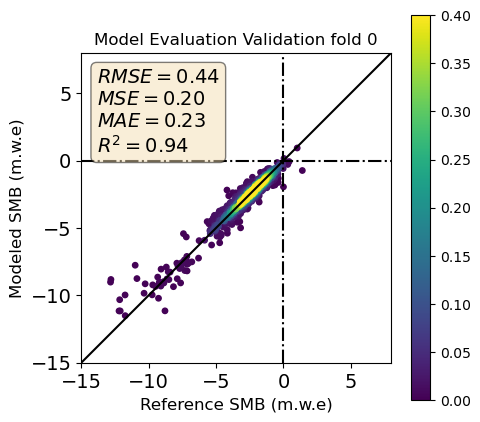

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


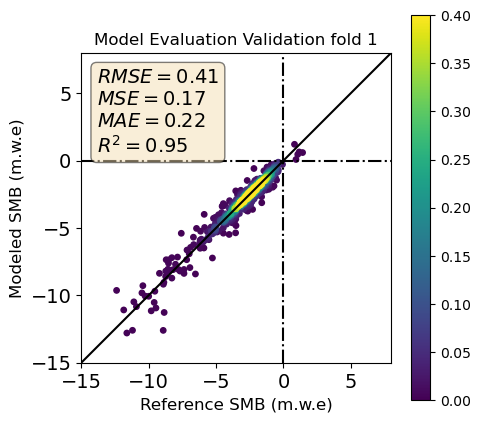

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


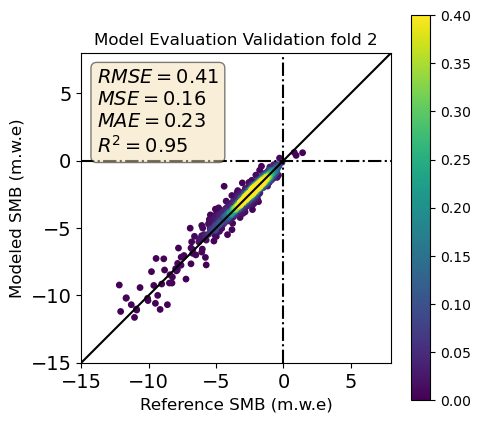

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


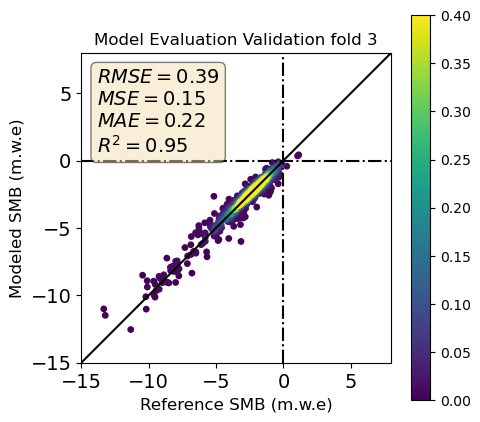

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


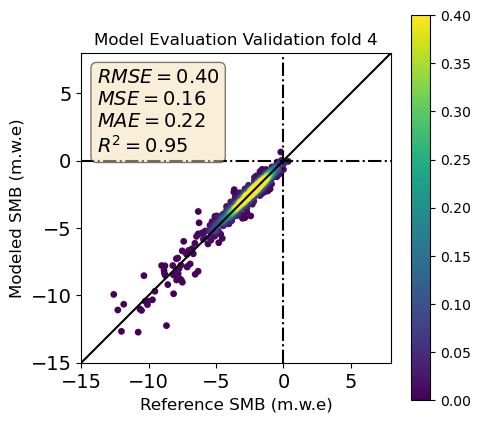

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


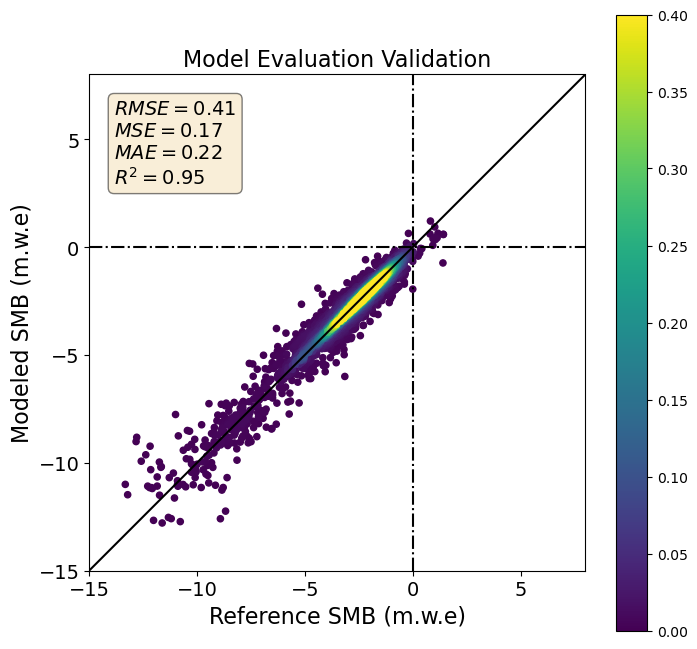

In [82]:
y_val_list = []
y_pred_list = []
i = 0

for train_index, val_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]
    fitted_model.fit(X_tr, y_tr)
    y_pred = fitted_model.predict(X_val)

    y_pred = y_pred.reshape(-1, 5).sum(axis=1)
    y_val = y_val.reshape(-1,5).mean(axis=1)
    
    y_val_list.extend(y_val)
    y_pred_list.extend(y_pred)

    title = 'Validation fold ' + str(i)

    plot_prediction(y_val, y_pred, title, n_toplot=10000, fold=True)

    i=i+1

    # Arrays of predictions and observations for each fold
    y_val_all = np.hstack([*y_val_list])
    y_pred_all = np.hstack([*y_pred_list])

# Plot predictions and observations for each cross-valiadation fold together
plot_prediction(y_val_all, y_pred_all, 'Validation', n_toplot=20000)

### Misc

In [ ]:
def plot_gsearch_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    width = len(grid.best_params_.keys())*5

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(width,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())
        ax[i].grid()

    plt.legend()
    plt.show()

In [37]:
performance_grid

{(3, 0.01): 0.38126800000000005,
 (3, 0.1): 0.19195199999999998,
 (3, 0.3): 0.2883084,
 (4, 0.01): 0.31664539999999997,
 (4, 0.1): 0.17216880000000004,
 (4, 0.3): 0.3244434,
 (5, 0.01): 0.25626340000000003,
 (5, 0.1): 0.1706796,
 (5, 0.3): 0.33783480000000005,
 (6, 0.01): 0.2232666,
 (6, 0.1): 0.170961,
 (6, 0.3): 0.362587}

In [64]:
# Train on full dataset and evaluate number of boosting rounds

# Convert to DMatrix
dtrain_full = xgb.DMatrix(X_train, label=y_train)

best_params_dict = {'max_depth': 4,
                   'eta': 0.1,
                   'gamma': 0}

# Train the model with early stopping to find the best number of boosting rounds
best_model = xgb.train(best_params_dict, dtrain_full, num_boost_round=500,
                       early_stopping_rounds=20, obj=seasonal_mse,
                       custom_metric=custom_mse,
                       evals=[(dtrain_full, 'full_data')], verbose_eval=False)

# The optimal number of boosting rounds
best_num_boost_round = best_model.best_iteration
print("Best Number of Boosting Rounds:", best_num_boost_round)

Best Number of Boosting Rounds: 499


(4917,)
(4917,)


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


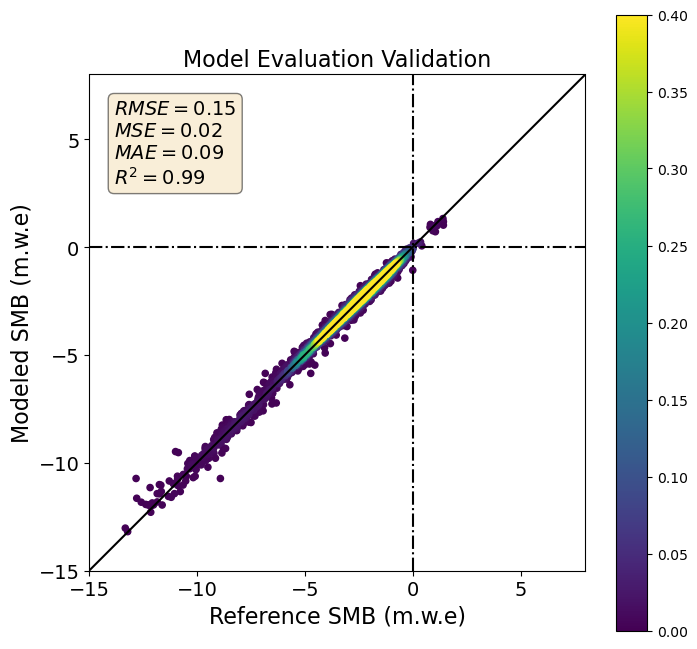

In [65]:
#test_model = cv_grid.best_estimator_
#test_model.fit(X_train, y_train)
y_pred_full = best_model.predict(dtrain_full)

y_pred_sum = y_pred_full.reshape(-1, 5).sum(axis=1)
print(y_pred_sum.shape)

y_train_full = dtrain_full.get_label()
y_train_mean = y_train_full.reshape(-1,5).mean(axis=1)
print(y_train_mean.shape)

plot_prediction(y_train_mean, y_pred_sum, data_type='Validation')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


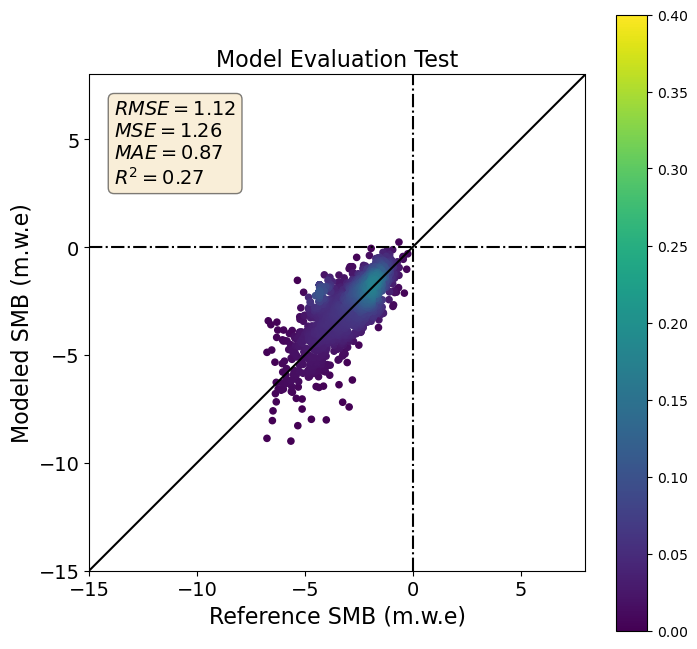

In [66]:
dtest = xgb.DMatrix(X_test)
preds_test = best_model.predict(dtest)
y_test_pred_sum = preds_test.reshape(-1, 5).sum(axis=1)
y_test_mean = y_test.reshape(-1,5).mean(axis=1)
plot_prediction(y_test_mean, y_test_pred_sum, data_type='Test')

In [115]:
preds = model.predict(dtrain)
print(preds[:5])
print(preds[:5].sum())
print(y_train[0])

[-0.41689366 -0.4550777  -0.47757766 -0.829338   -0.66489935]
-2.8437865
[-2.98]


In [116]:
print(preds[5])


-0.37203494


In [117]:
preds = model.predict(dtrain)
print(preds[5:10])
print(preds[5:10].sum())
print(y_train[5])

[-0.37203494 -0.43014026 -0.41372335 -0.38544875 -0.26398343]
-1.8653307
[-1.79]


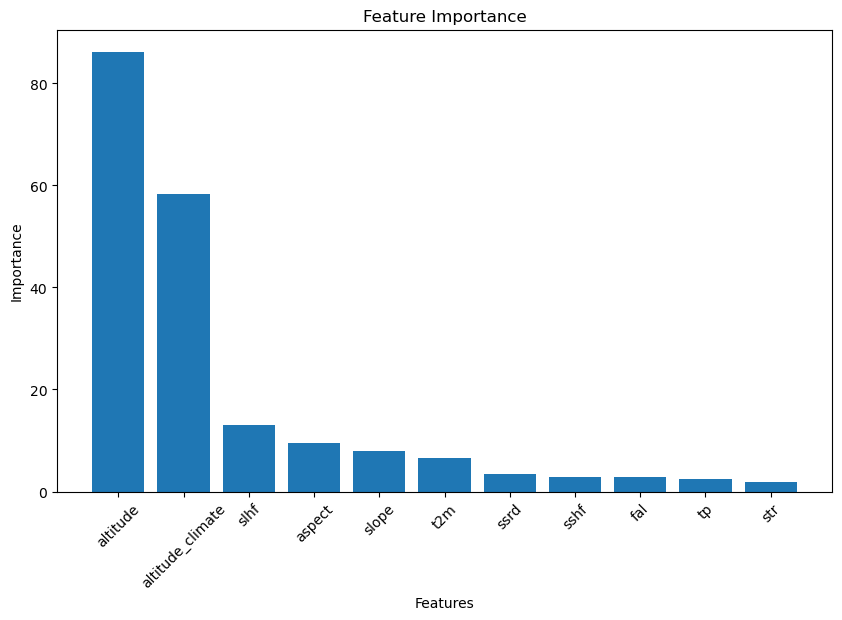

In [118]:
# Feature importance: gain
#Gain:
#Description: Gain measures the average gain of a feature when it is used in trees. The gain is a measure of the improvement in accuracy brought by a feature to the branches it is on.
#Interpretation: A higher gain value when a feature is used implies the feature is more useful for improving the model's performance. Gain is a more nuanced metric compared to weight, as it takes into account the effectiveness of each feature in improving the model.
#Use Case: This is often considered the most important metric, as it gives a clearer indication of the contribution of each feature to the model's predictive power.

# Get the feature names from the DataFrame
feature_names = df_train_X.columns

# Map 'f0', 'f1', etc. to actual feature names
fmap = {f'f{i}': name for i, name in enumerate(feature_names)}

# Get feature importance and map feature names
feature_importance = model.get_score(importance_type='gain')
feature_importance = {fmap[k]: v for k, v in feature_importance.items()}

# Sorting the features based on importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.xticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

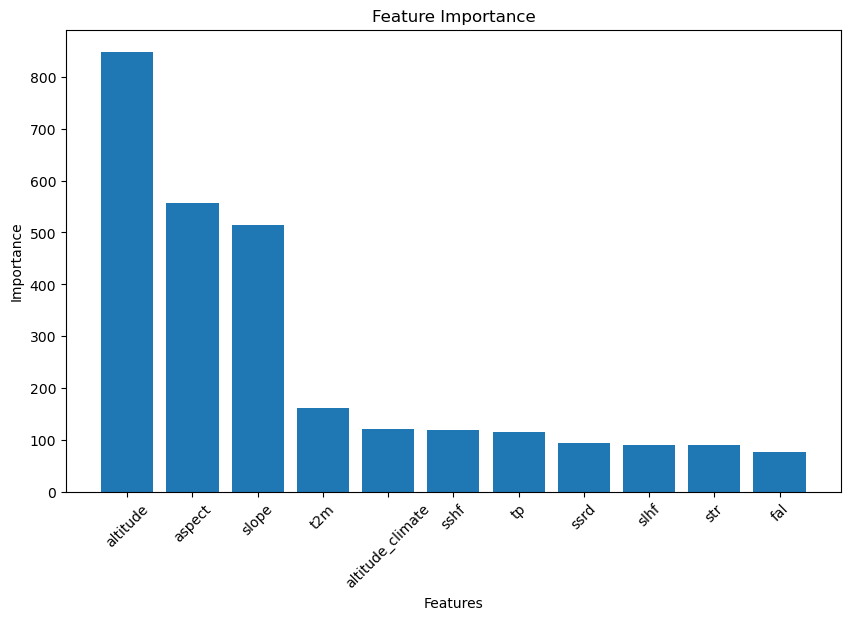

In [119]:
# Feature importance: weight
#Weight (Frequency):
#Description: This metric counts the number of times a feature is used to split the data across all trees.
#Interpretation: A feature with a higher weight has been used more often in decision nodes of trees. This indicates it's generally more important for making splits, but doesn't necessarily imply a strong predictive power.
#Use Case: Useful for understanding which features are frequently considered in the model's decision-making process.

# Get the feature names from the DataFrame
feature_names = df_train_X.columns

# Map 'f0', 'f1', etc. to actual feature names
fmap = {f'f{i}': name for i, name in enumerate(feature_names)}

# Get feature importance and map feature names
feature_importance = model.get_score(importance_type='weight')
feature_importance = {fmap[k]: v for k, v in feature_importance.items()}

# Sorting the features based on importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.xticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

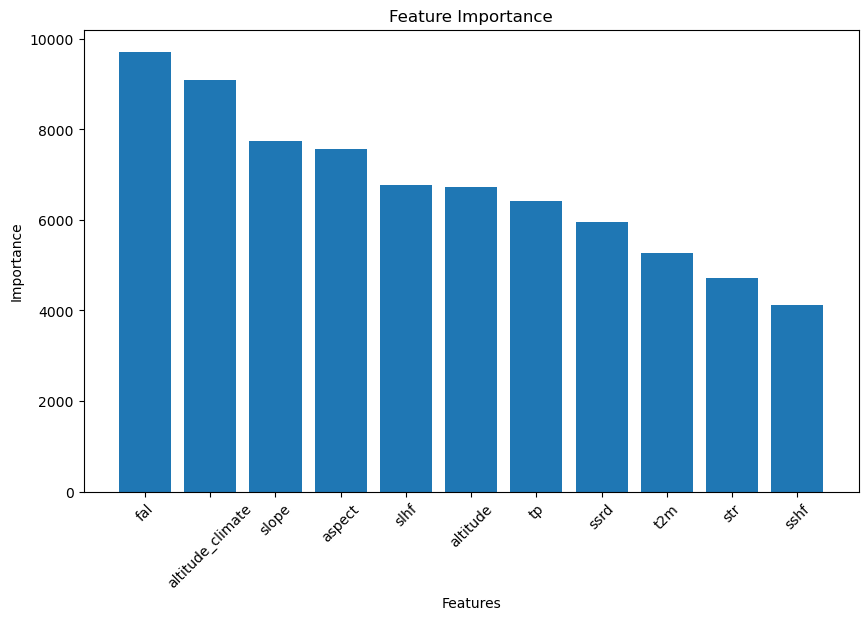

In [105]:
# Feature importance cover: 
#Cover:
#Description: Cover measures the average coverage of a feature when it is used in trees. Coverage is defined as the number of samples affected by the split.
#Interpretation: A higher cover value indicates that the feature is used in splits that affect more samples. It gives an idea of the range of influence of the feature in the dataset.
#Use Case: Useful for understanding the impact of a feature on the data distribution in the model.

# Get the feature names from the DataFrame
feature_names = df_train_X.columns

# Map 'f0', 'f1', etc. to actual feature names
fmap = {f'f{i}': name for i, name in enumerate(feature_names)}

# Get feature importance and map feature names
feature_importance = model.get_score(importance_type='cover')
feature_importance = {fmap[k]: v for k, v in feature_importance.items()}

# Sorting the features based on importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.xticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

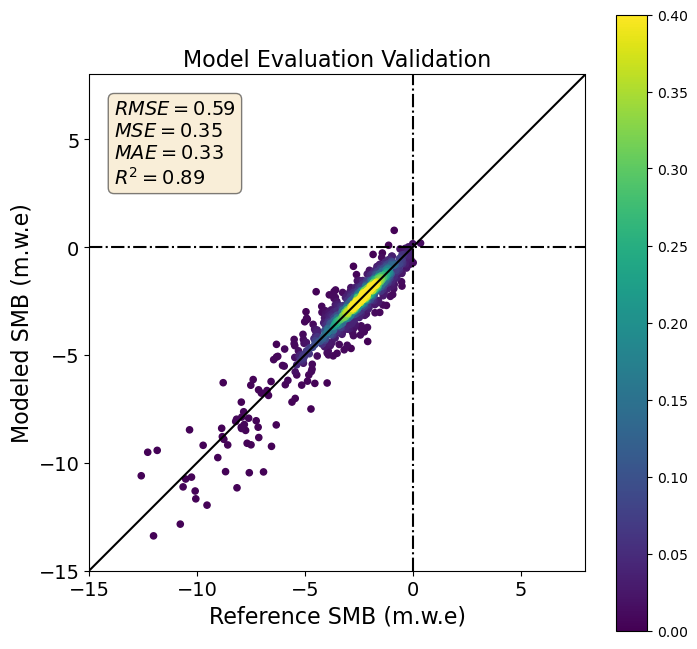

### Test model

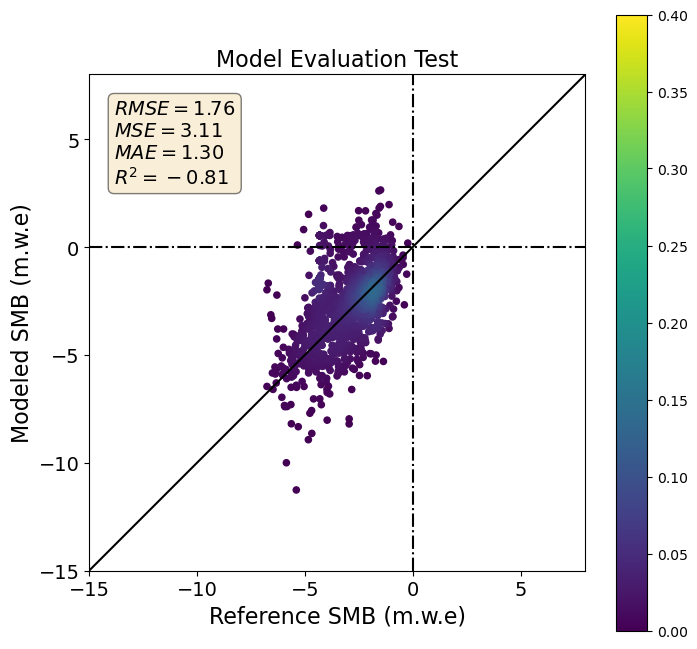

## Model training with hyperparameter search